In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import glob
from stem_lstm import align_spectrum, scale_spectrum, LSTM_format

# For Keras LSTM model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback

# For hyperopt
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp

In [2]:
# Load signals from files in the path with specified dwell time
path = '../data/dwell_time0.4s'
signals = []

for file in glob.glob(path+'/*'):
    signals.append(hs.load(file))
    
# Print array sizes, beam energy, and dwell time
for s in signals:
    print('shape:',s[2].data.shape)
    print('beam energy:',s[2].metadata.Acquisition_instrument.TEM.beam_energy)
    print('dwell time:',s[2].metadata.Acquisition_instrument.TEM.Detector.EELS.dwell_time,'\n')

shape: (120, 2048)
beam energy: 300.0
dwell time: 0.4 

shape: (160, 2048)
beam energy: 300.0
dwell time: 0.4 

shape: (160, 2048)
beam energy: 300.0
dwell time: 0.4 



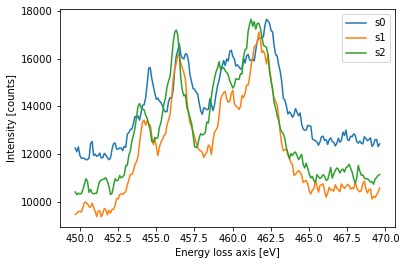

In [3]:
# Assign EELS spectrum to s variable
s0 = signals[0][2]
s1 = signals[1][2]
s2 = signals[2][2]

# Align spectra
s0_aligned = align_spectrum(s0)
s1_aligned = align_spectrum(s1)
s2_aligned = align_spectrum(s2)

# Extract bin size, scale, and offset for accurate plotting
scale = s0_aligned.axes_manager[1].scale
size = s0_aligned.axes_manager[1].size
offset = s0_aligned.axes_manager[1].offset

# Define energy scale
e_min = offset
e_max = offset + size * scale
e = np.linspace(e_min, e_max, size)

# Plot newly aligned spectra
start = 150
end = 350
timestep = 0
plt.plot(e[start:end],s0_aligned.data[timestep][start:end],label='s0')
plt.plot(e[start:end],s1_aligned.data[timestep][start:end],label='s1')
plt.plot(e[start:end],s2_aligned.data[timestep][start:end],label='s2')
plt.xlabel('Energy loss axis [eV]')
plt.ylabel('Intensity [counts]')
plt.legend();

In [4]:
s0_scaled, scaler = scale_spectrum(s0_aligned,return_scaler = True)
s1_scaled = scaler.transform(s1_aligned)
s2_scaled = scaler.transform(s2_aligned)

In [5]:
from hyperopt.pyll.base import scope #quniform returns float, some parameters require int; use this to force int

space = {'rate'         : hp.uniform('rate',0.01,0.3),
         'units'        : scope.int(hp.quniform('units',64,512,5)),
         'batch_size'   : scope.int(hp.quniform('batch_size',20,100,10)),
         'layers'       : scope.int(hp.quniform('layers',1,4,1)),
         'window'       : scope.int(hp.quniform('window',3,15,1)),
         'learning_rate': hp.loguniform('learning_rate', -12, -2)
        }

loss='mean_squared_error' # tf.keras.losses.CosineSimilarity()
window_forward = 8

In [6]:
def lstm(params):
    # Generate data with given window
#     Xtrain, ytrain, Xtest, ytest = format_data(window=params['window'])
    X_train1, y_train1 = LSTM_format(s0_scaled, window_back=params['window'], window_forward = window_forward)
    X_train2, y_train2 = LSTM_format(s1_scaled, window_back=params['window'], window_forward = window_forward)
    X_train3, y_train3 = LSTM_format(s2_scaled, window_back=params['window'], window_forward = window_forward)

    X = np.concatenate([X_train1,X_train2,X_train3])
    y = np.concatenate([y_train1,y_train2,y_train3])
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    # Keras LSTM model
    model = Sequential()
    
    if params['layers'] == 1:
        model.add(LSTM(units=params['units'], input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
        model.add(Dropout(rate=params['rate']))
    else:
        # First layer specifies input_shape and returns sequences
        model.add(LSTM(units=params['units'], return_sequences=True, input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
        model.add(Dropout(rate=params['rate']))
        # Middle layers return sequences
        for i in range(params['layers']-2):
            model.add(LSTM(units=params['units'],return_sequences=True))
            model.add(Dropout(rate=params['rate']))
        # Last layer doesn't return anything
        model.add(LSTM(units=params['units']))
        model.add(Dropout(rate=params['rate']))

    model.add(Dense(ytrain.shape[1]))
    
    opt = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=opt, loss='mean_squared_error')
    
    es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=100)

    result = model.fit(Xtrain, ytrain, verbose=0, validation_split=0.1,
                       batch_size=params['batch_size'],
                       epochs=3000,
                       callbacks=[es,TqdmCallback(verbose=1)]
                      )
    
    # Print params used
    print(params)
    
    #get the lowest validation loss of the training epochs
    validation_loss = np.amin(result.history['val_loss']) 
    print('Best validation loss of epoch:', validation_loss)
    
    # Plot loss curve
    plt.semilogy(result.history['loss'], label='loss')
    plt.semilogy(result.history['val_loss'], label='val_loss',alpha=0.9)
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    
    
    return {'loss': validation_loss, 'status': STATUS_OK, 'model': model, 
            'params': params, 'Xtest': Xtest, 'ytest': ytest, 'result': result}

  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

Epoch 00449: early stopping                                                                                            
{'batch_size': 70, 'layers': 2, 'learning_rate': 0.0052228057054530515, 'rate': 0.1788790792335687, 'units': 200, 'window': 13}
Best validation loss of epoch:                                                                                         
0.015524459071457386                                                                                                   
  0%|                                                                            | 0/1 [05:33<?, ?trial/s, best loss=?]

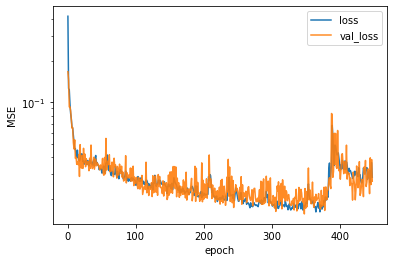

100%|███████████████████████████████████████████████| 1/1 [05:34<00:00, 334.38s/trial, best loss: 0.015524459071457386]


In [7]:
trials = Trials()
best = fmin(lstm, space, algo=tpe.suggest, max_evals=1, trials=trials)

# best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
best_window = best_params['window']
# best_model.save('LSTM_0.4s.h5')

# worst_model = trials.results[np.argmax([r['loss'] for r in trials.results])]['model']
worst_params = trials.results[np.argmax([r['loss'] for r in trials.results])]['params']
worst_window = worst_params['window']

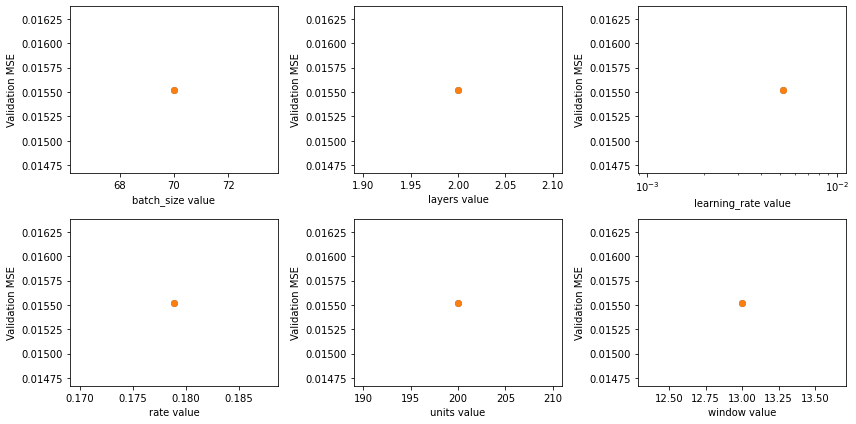

In [8]:
trials_losses = [x['loss'] for x in trials.results]
trials_params = [x['params'] for x in trials.results]

params_list = list(trials_params[0].keys())

fig, ax = plt.subplots(2,3,figsize=(12,6))
for i,param in enumerate(params_list):
    row = i//3
    col = i%3
    param_list = [x[param] for x in trials_params]
    ax[row][col].scatter(param_list,trials_losses)
    ax[row][col].scatter(best_params[param],np.min(trials_losses))
    if param == 'learning_rate':
        ax[row][col].set_xscale('log')
    ax[row][col].set_xlabel(param+' value')
    ax[row][col].set_ylabel('Validation MSE')
plt.tight_layout()

Epoch 00424: early stopping

{'batch_size': 70, 'layers': 2, 'learning_rate': 0.0052228057054530515, 'rate': 0.1788790792335687, 'units': 200, 'window': 13}
Best validation loss of epoch: 0.016804812476038933


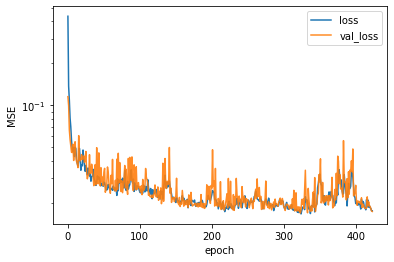

In [9]:
final = lstm(best_params)

Xtest = final['Xtest']
ytest = final['ytest']

In [10]:
yp_s = best_model.predict(Xtest)
yp = scaler.inverse_transform(yp_s)
ytest_us = scaler.inverse_transform(ytest)

plt.plot(e,ytest_us[-1], label='real')
plt.plot(e,yp[-1],':', label='predicted')
plt.legend()
plt.xlabel('Energy loss axis (eV)')
plt.ylabel('Intensity (counts)')

NameError: name 'best_model' is not defined

In [ ]:
#### Results ####
epochs = es.stopped_epoch

# Plot epochs and loss
plt.semilogy(result.history['loss'], label='training loss')
plt.semilogy(result.history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()

# Save model


In [ ]:
plt.plot(e,y_test[-1], label='real')
plt.plot(e,yp[-1], label='predicted')
plt.legend()


In [ ]:
# Predict on test set
yp_scaled = model.predict(Xtest)
yp = scaler.inverse_transform(yp_scaled)
y_test = scaler.inverse_transform(ytest)

# Plot zoomed in on Ti peaks
start, end =150, 350# 800-1300 for O edge

# storing prediction MSE and MSE calculated based on using the last input point as the prediction
mse = []

for point_to_predict in range(0,len(y_test)):
    input_seq = Xtest[point_to_predict]
    input_seq = np.reshape(input_seq,[1,input_seq.shape[0],input_seq.shape[1]])
    
    prediction_s = model.predict(input_seq)
    prediction = scaler.inverse_transform(prediction_s)[0]
    
    # Calculate and store MSEs
    mse.append(mean_squared_error(prediction,y_test[point_to_predict]))
    
    # plot
    if point_to_predict % 10 == 0:
        plt.plot(e[start:end],y_test[point_to_predict][start:end],label='real')
        plt.plot(e[start:end],prediction[start:end],label='prediction')
        plt.legend()
        plt.xlabel('Energy loss axis [eV]')
        plt.ylabel('Intensity [counts]')
        plt.show()
        
print('Prediction MSE:',np.mean(mse),u'\u00B1',np.std(mse))


In [ ]:
# Plot input sequence, real, and prediction
for i, input_spec in enumerate(Xtest[point_to_predict]):
    input_spec_us = scaler.inverse_transform(input_spec.reshape(1,-1))
    if i == 4:
        plt.plot(e,input_spec_us[0],':',color='black',alpha = (i+2)/15,label='input_sequence')
    else:
        plt.plot(e,input_spec_us[0],':',color='black',alpha = (i+2)/15)
plt.plot(e,y_test[point_to_predict],label='real')
plt.plot(e,prediction,label='prediction')
plt.legend()
plt.xlabel('Energy loss axis [eV]')
plt.ylabel('Intensity [counts]')
plt.show()